In [485]:
## Should have all the same signal processing functions from the signal package in R:
## https://cran.r-project.org/web/packages/signal/signal.pdf
from scipy.signal import butter, lfilter

## https://docs.scipy.org/doc/scipy/reference/signal.html

import pandas as pd
import numpy as np
import csv
import glob
import json
import re
import matplotlib.pyplot as plt
import datetime

Output to a mapped dropbox folder: /Users/dancohen/Dropbox/E4 stuff/test data/EDA_Test_Data_Analysis

In [486]:
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/EDA_Test_Data_Analysis'

Define helper functions to convert from the unix timestamp to UTC and to add time to an input date based on a sample rate (will be 4hz for this code)

In [487]:
def get_utc_date_time(ts):
    return datetime.datetime.fromtimestamp(ts)
#.strftime('%H:%M:%S:%f')

def add_fs(sample_rate, date):
    return date + datetime.timedelta(milliseconds=1.0/(sample_rate) * 1000.0)

Found some code on stack overflow and in SciPy's community website that implements a band pass butterworth filter for a 1d array: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html#.  I dont know what order filter we need for this data, but for exploratory data analysis, it appears to work ok

In [488]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

## May need to better understand which order filter is needed for this dataset
def butter_bandpass_filter(data, lowcut, highcut, fs, column_name, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    y = pd.DataFrame(y, columns=[column_name])
    return y

Take all the CSV files in the test data folder and concatenate them together.

For this exploratory analysis, we would like to plot against timepoints.  The data supplied for each EDA is in 1 column (including the original timestamp), so we must transpose the data frame so that each column becomes 1 row in the eventual dataset.  

Ie, 1 column with 8k rows becomes 8k columns (representing timepoints) with 1 row (representing the entire run)

In [489]:
file_path = r'/Users/dancohen/Code_Projects/Empatica E4 Analysis/EDA_Test_data'
all_files = glob.glob(file_path + "/*.csv")

In [490]:
fs = 4.0 ## Sampling frequency.  This test data was gathered at 4hz
lowcut = 0.05 ## Lower bound for the filter, as directed by Empatica documentation
highcut = 1.0  ## Upper bound for the filter, as directed by Empatica documentation

In [497]:
unfiltered_EDA = []
filtered_EDA = []

for file_path in all_files:
    datetime_range = []
    
    path = file_path.split('/')
    
    #Grabs the 3 digit pariticipant code in the test file names (I added these manually to the file names)
    csv = path[len(path)-1]
    file_code = csv[5:7]

    df = pd.read_csv(file_path)
    # For this test data, we dont care about the first row, which is the timestamp. 
    # NOTE: The sampling rate of 4hz is found in the second row of each csv file, so we just drop that row as well
    # https://support.empatica.com/hc/en-us/articles/201608896-Data-export-and-formatting-from-E4-connect-
    
    df = df.drop(df.index[0:2])
   
    # Generate list of date times, iterated upwards by 1/sampling frequency seconds (1/4 in this case)
    # Once list is generated, add as a new column to the dataframe

    date = get_utc_date_time(float(df.columns[0])) #The original t0 timestamp is the column header name
    datetime_range.append(date.strftime('%H:%M:%S:%f'))
    next_date = date
    
    for count in range(len(df)-1):
        next_date = add_fs(4, next_date)
        datetime_range.append(next_date.strftime('%H:%M:%S:%f'))
    
    # Once we're done with creating a timestamp list, just rename the column containing the 
    # data to the participant ID
    df = df.rename(columns={df.columns[0]: file_code})
    
    #Output files with timestamps (based on t0 - first line in file) for filtered data
    filtered_entry = butter_bandpass_filter(df[file_code], lowcut, highcut, fs, file_code)
    filtered_entry['Time Stamp'] = datetime_range
    unfiltered_entry = df
    unfiltered_entry['Time Stamp'] = datetime_range
    
    #Uncomment these lines to show filtered plots across timestamps
    #filtered_entry.plot(x='Time Stamp', y=file_code)
    #plt.show()
    
    filtered_entry.to_csv(output_path+'/filteredEDA{}_timestamped.csv'.format(file_code))
    
    unfiltered_EDA.append(df.transpose())
    filtered_EDA.append(butter_bandpass_filter(df[file_code], lowcut, highcut, fs, file_code).transpose())
    
unfiltered_frame = pd.concat(unfiltered_EDA)
filtered_frame = pd.concat(filtered_EDA)

We are transposing the entire dataframe back into 4 columns and ~8k rows just to make doing simple graphs easier.  Turns out that using matplotlib's plot.show() by default looks at each column as a line in the plot

In [492]:
filtered_frame = filtered_frame.transpose()
unfiltered_frame = unfiltered_frame.transpose()

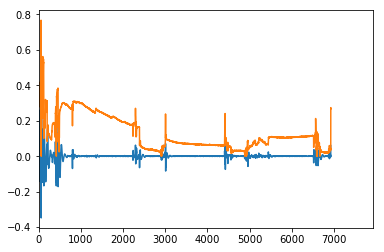

In [493]:
filtered_frame['05'].plot()
unfiltered_frame['05'].plot()
plt.show()

In [494]:
filtered_frame.to_csv(output_path+'/filteredEDA.csv')
unfiltered_frame.to_csv(output_path+'/unfilteredEDA.csv')